In [1]:
import warnings
warnings.filterwarnings("ignore")

from pandas_datareader import data as pdr 
import yfinance as yf #yahoo finance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import datetime
from datetime import timedelta
from datetime import datetime
yf.pdr_override() ## necessário para reconhecer as datas no formato datetime

In [2]:
# importanto médido interno ARIMA

from statsmodels.tsa.arima.model import ARIMA

def MA_model_generation(ts, q):
    model = ARIMA(ts, order = [0, 0, q]) 
    
    # os parâmetros 0, 0, q correspondem a: 
    
    #p: The number of lag observations included in the model, also called the lag order.
    #d: The number of times that the raw observations are differenced, also called the degree of differencing.
    #q: The size of the moving average window, also called the order of moving average.

    # no modelo de médias móveis, por definição, p e d são zero.
    
    model_fit = model.fit()
    return model_fit

In [3]:
def captura_yahoofn (ticket,start,end):
    
    ticket=ticket+'.SA'
    cotacao = pdr.get_data_yahoo(ticket, start, end)
    cotacao = cotacao.rename(columns={'Adj Close': 'Adj_Close'})
    serie=pd.DataFrame({"DATA":cotacao.index})
    serie.insert(1,'Fechamento',np.array(cotacao.Adj_Close))
    
    return serie

In [4]:
def gera_curva_MA (serie,grau):
    MA_otimo = MA_model_generation(serie.Fechamento, grau)
     
    return MA_otimo

In [5]:
def cria_dataset (serie,MA):
    serie_gerada = serie.copy()
    size = serie.shape[0]
    
    for i in range(size):
        serie_gerada.Fechamento[i]=MA.predict(i)[i]
        
    return serie_gerada

In [6]:
def mostra_curva(ticket,serie):
    plt.figure( figsize=(21, 7))

    plt.title(ticket)
    plt.plot(serie.DATA,serie.Fechamento)
    plt.xlabel("Data")
    plt.ylabel("Fechamento")

    plt.show()

In [7]:
def compara_series (ticket,original,calculada):
    plt.figure( figsize=(21, 7))

    plt.title(ticket+" - Fechamento e curva calculada")
    plt.plot(original.DATA,original.Fechamento)
    plt.plot(original.DATA,calculada.Fechamento, c='red')
    plt.legend(['valor original', 'Curva calculada']);
    plt.xlabel("Data")
    plt.ylabel("Valor")

    plt.show()

    print('Erro calculado = ',erro (original,calculada))

In [8]:
def gera_previsao (original,MA,qt_dias):
    size = original.shape[0]
    lastday = original.DATA[size-1]  
    período_previsto = qt_dias

    previsao = pd.DataFrame({"DATA":np.array([lastday+timedelta(i) for i in range (período_previsto)]),
                     "Fechamento":np.array(MA.predict(i)[i] for i in range (size, size + período_previsto))})
                     

    # ajustar todos os feriados aqui
    feriados = [datetime(2023, 9, 7),datetime(2023, 10, 12),datetime(2023, 11, 2),
               datetime(2023, 11, 15),datetime(2023, 12, 25),datetime(2023, 12, 29)]

    nextday=lastday
    for i in range (período_previsto):
        nextday=nextday+timedelta(1)
        if nextday in feriados:
            nextday=nextday+timedelta(1)
        if nextday.weekday()==5:     # descontando sábados e domingos - gambiarra
            nextday=nextday+timedelta(2) 
        previsao.DATA[i]=nextday
    return previsao

In [9]:
def erro (serie1,serie2):
    soma=0
    size=min(serie1.shape[0],serie2.shape[0])
    
    for i in range (size):
        dif=abs(serie1.Fechamento[i]-serie2.Fechamento[i])
        if dif<1:
            soma+=dif
        else:
            soma+=dif**2                 
        
    return soma

In [10]:
def mostra_previsao(acao,original,previsao):
    size = original.shape[0]
    lastday = original.DATA[size-1] 
    
    serie_MA = pd.concat([original, previsao], axis=0)
    serie_MA.reset_index(inplace=True, drop=True)
    
    plt.figure( figsize=(21, 7))
    plt.title(acao+" + previsão")
    plt.plot(serie_MA.DATA,serie_MA.Fechamento, c="blue")
    plt.legend(['Fechamento']);
    plt.vlines(lastday,min(original.Fechamento),max(original.Fechamento), color='green')
    plt.xlabel("DATA")
    plt.ylabel("VALORES")

    plt.show()
    

### iniciando uma captura com um papel qualquer

In [ ]:
acao='AZUL4'
inicio = datetime(2023, 1, 1)
fim = datetime(2023, 9, 21)

In [ ]:
datasetinicial = captura_yahoofn(acao,inicio,fim)

In [ ]:
datasetinicial

In [ ]:
mostra_curva(acao,datasetinicial)

## vamos recapturar a partir de junho/2023

In [ ]:
inicio = datetime(2023, 6, 1)
fim = datetime(2023, 9, 21)
datasetinicial = captura_yahoofn(acao,inicio,fim)

In [ ]:
mostra_curva(acao,datasetinicial)

In [ ]:
## calculando a curva ótima e regando um dataset com a mesma

curva_otima = gera_curva_MA(datasetinicial,35)
serie_calculada = cria_dataset(datasetinicial,curva_otima)

In [ ]:
serie_calculada

In [ ]:
## sobrepondo as curvas

compara_series(acao,datasetinicial,serie_calculada)

In [ ]:
## prevendo os próximos 30 dias

previsao = gera_previsao(datasetinicial,curva_otima,30)

In [ ]:
mostra_previsao(acao,datasetinicial,previsao)

## testando outros papéis

In [ ]:
acao = 'PNVL3'
inicio = datetime.datetime(2023, 6, 1)
fim = datetime.datetime(2023, 9, 21)
datasetinicial = captura_yahoofn(acao,inicio,fim)

In [ ]:
mostra_curva(acao,datasetinicial)

In [ ]:
curva_otima = gera_curva_MA(datasetinicial,35)
serie_calculada = cria_dataset(datasetinicial,curva_otima)

In [ ]:
compara_series(acao,datasetinicial,serie_calculada)

In [ ]:
previsao = gera_previsao(datasetinicial,curva_otima,30)

In [ ]:
previsao

In [ ]:
mostra_previsao(acao,datasetinicial,previsao)

## montando script com a sequencia de passos

In [15]:
def script():
    papel = input("Informe a ação que quer pesquisar: (ex CVCB3)")
    inicio = input("Informe a ação data inicial: (dd/mm/aaaa)")
    begin = datetime.strptime(inicio, '%d/%m/%Y').date()
    fim = input("Informe a ação data final: (dd/mm/aaaa)")
    end = datetime.strptime(fim, '%d/%m/%Y').date()
    grau = int(input("Informe o grau de precisão da curva: "))
    periodo = int(input("Informe o período em dias que quer prever: "))
    
    datasetinicial = captura_yahoofn(papel,begin,end)
    mostra_curva(papel,datasetinicial)
    
    print("Calculando curva ótima")
    curva_otima = gera_curva_MA(datasetinicial,grau)
    serie_calculada = cria_dataset(datasetinicial,curva_otima)
    
    compara_series(papel,datasetinicial,serie_calculada)
    previsao = gera_previsao(datasetinicial,curva_otima,periodo)
    mostra_previsao(papel,datasetinicial,previsao)

Informe a ação que quer pesquisar: (ex CVCB3)bbas3
Informe a ação data inicial: (dd/mm/aaaa)01/06/2023
Informe a ação data final: (dd/mm/aaaa)21/09/2023
Informe o grau de precisão da curva: 35
Informe o período em dias que quer prever: 15
[*********************100%%**********************]  1 of 1 completed


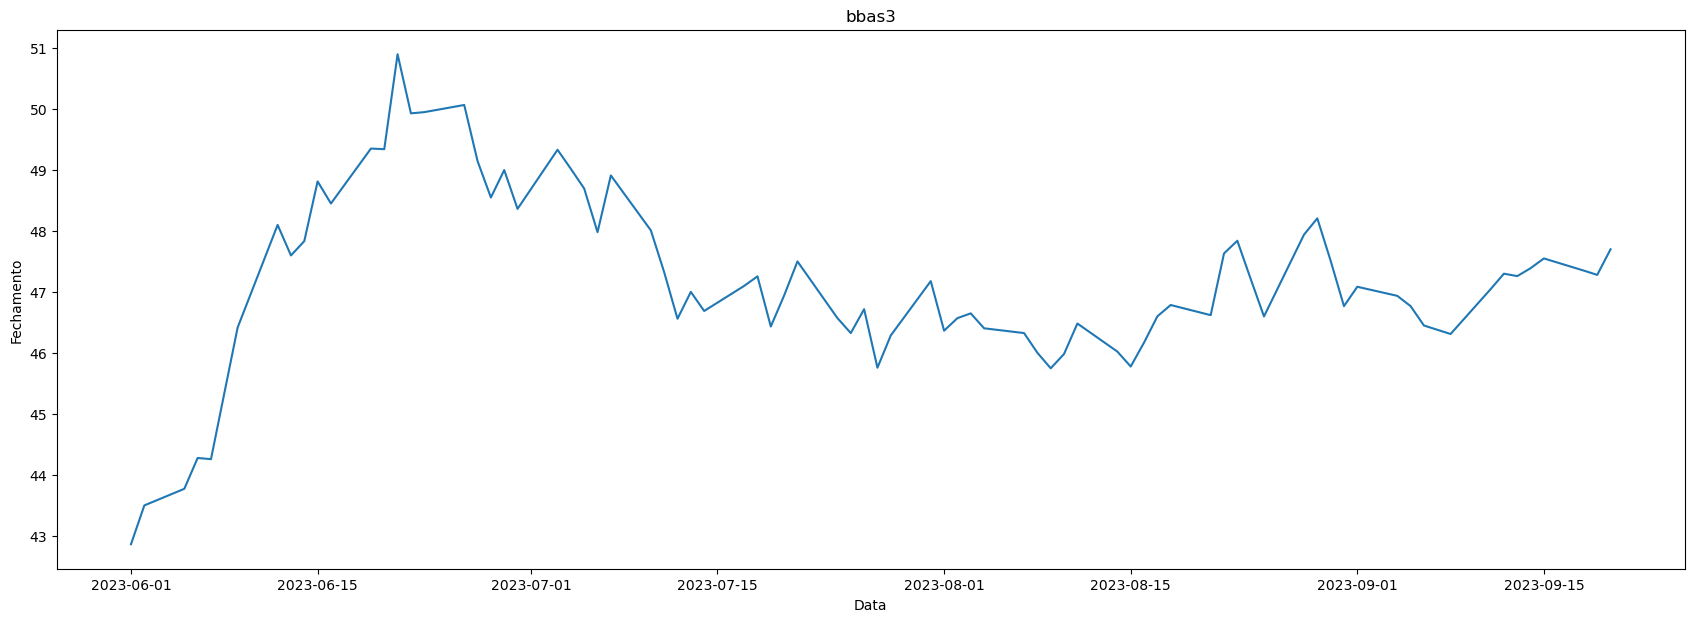

Calculando curva ótima


C:\Users\Paulo\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


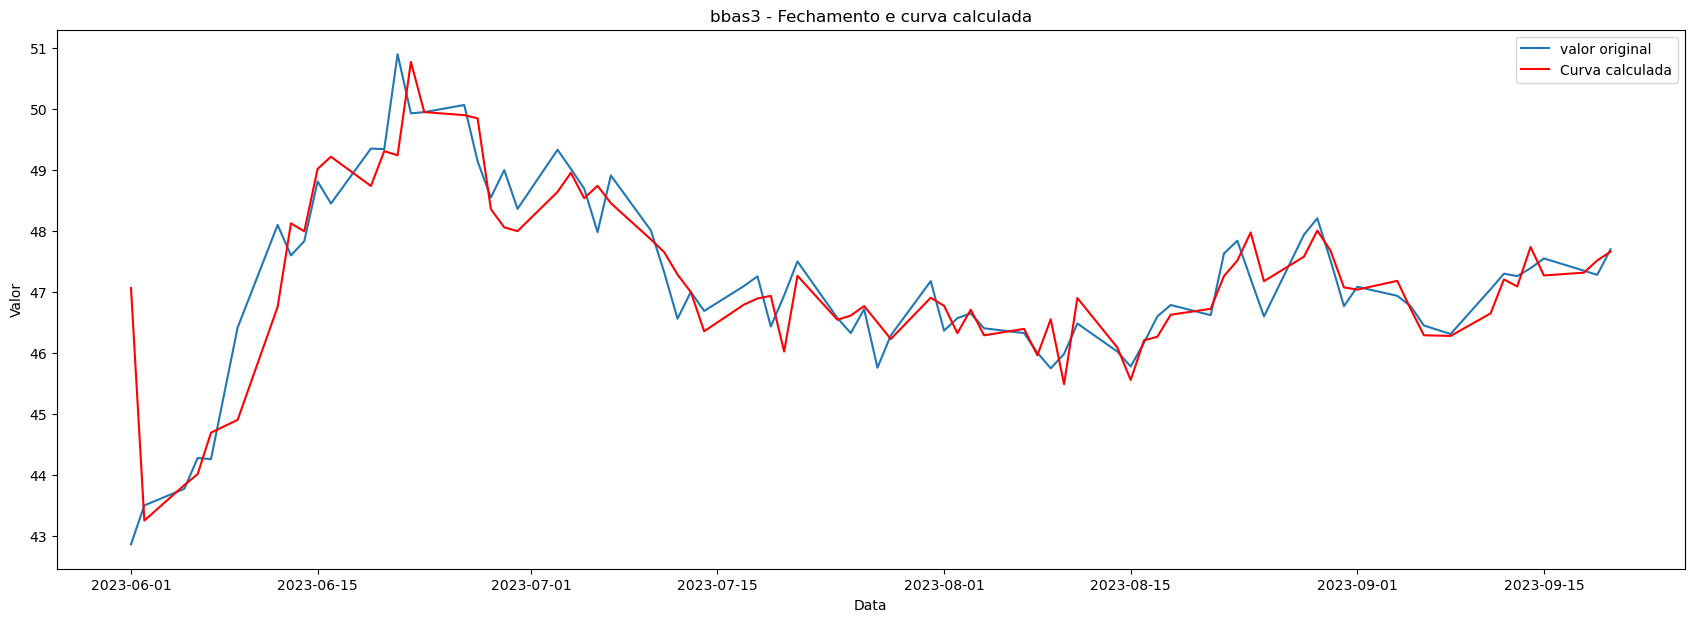

Erro calculado =  47.194342325253785


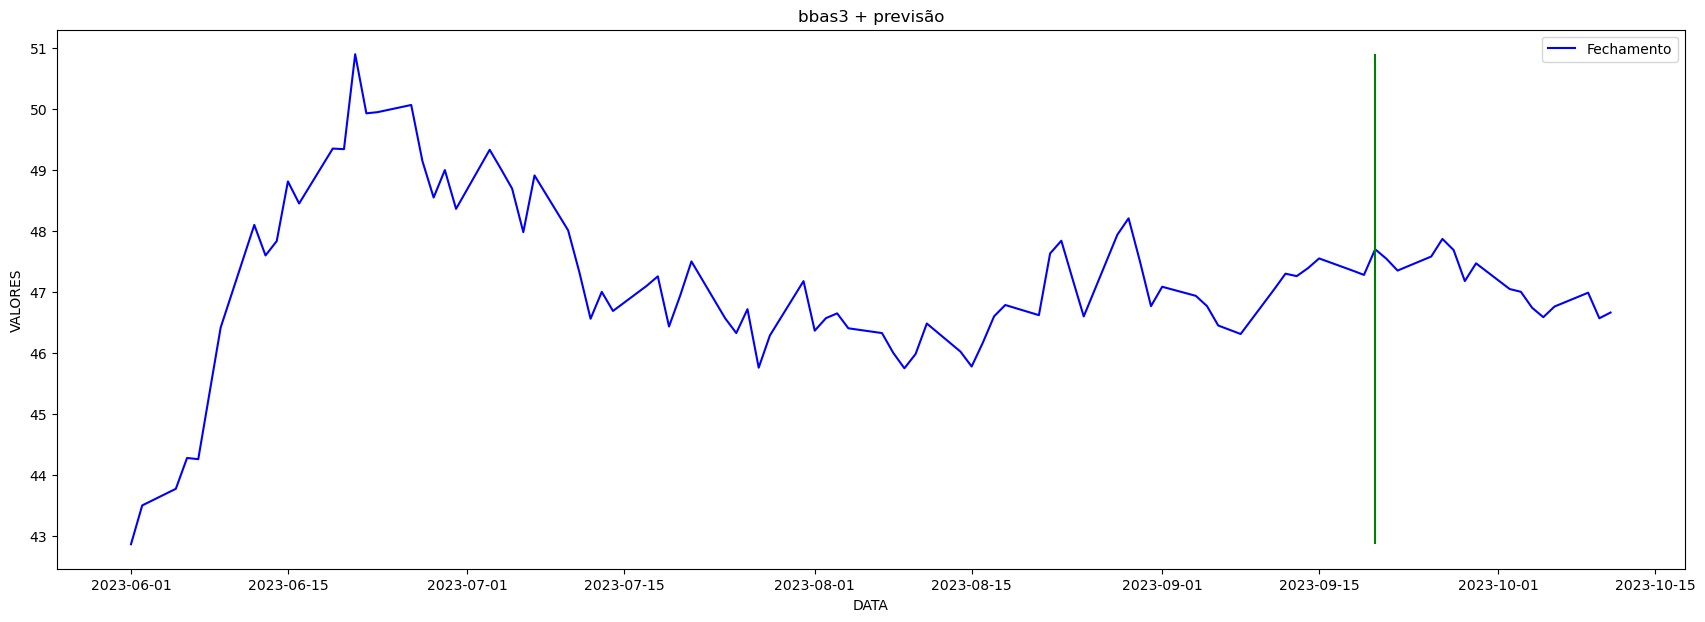

In [16]:
script()

Informe a ação que quer pesquisar: (ex CVCB3)ITUB3
Informe a ação data inicial: (dd/mm/aaaa)01/01/2023
Informe a ação data final: (dd/mm/aaaa)21/09/2023
Informe o grau de precisão da curva: 60
Informe o período em dias que quer prever: 30
[*********************100%%**********************]  1 of 1 completed


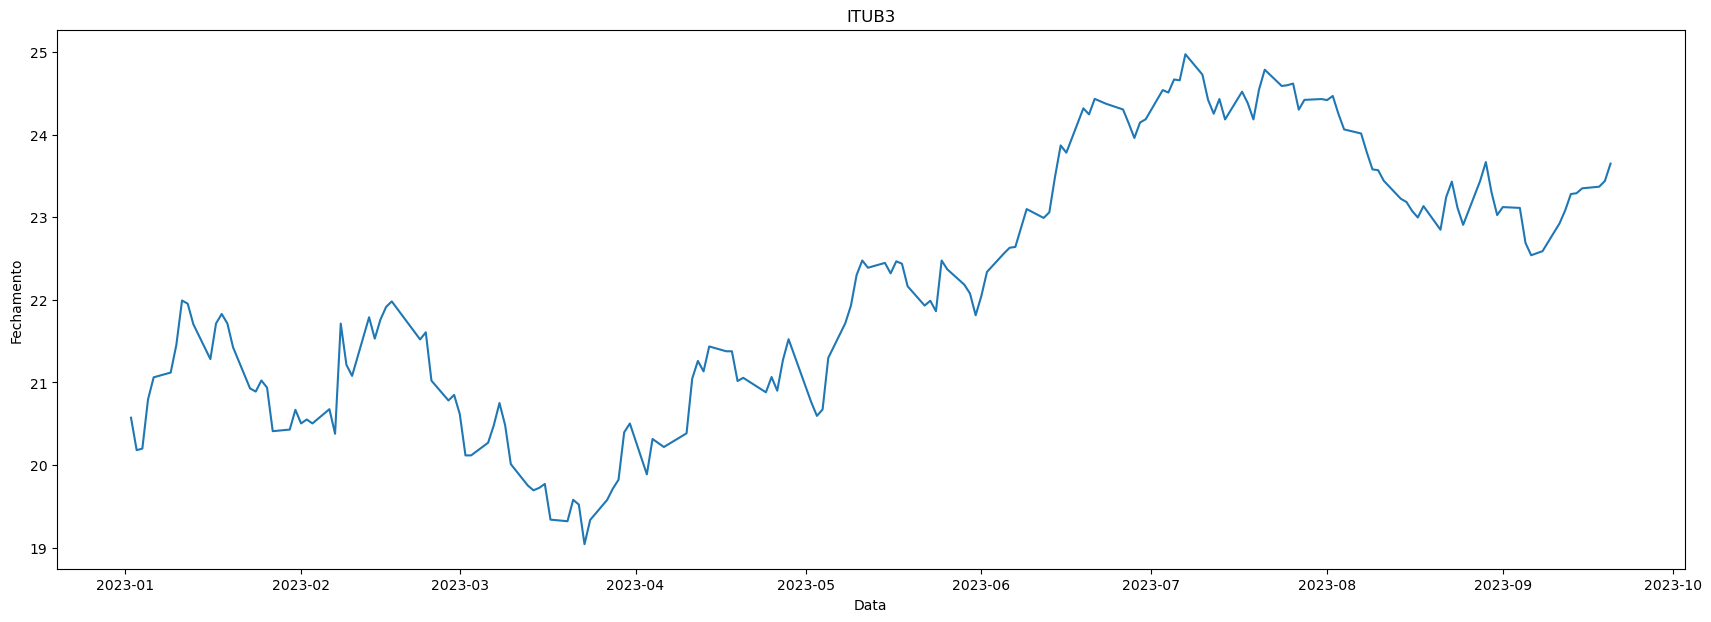

Calculando curva ótima


C:\Users\Paulo\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


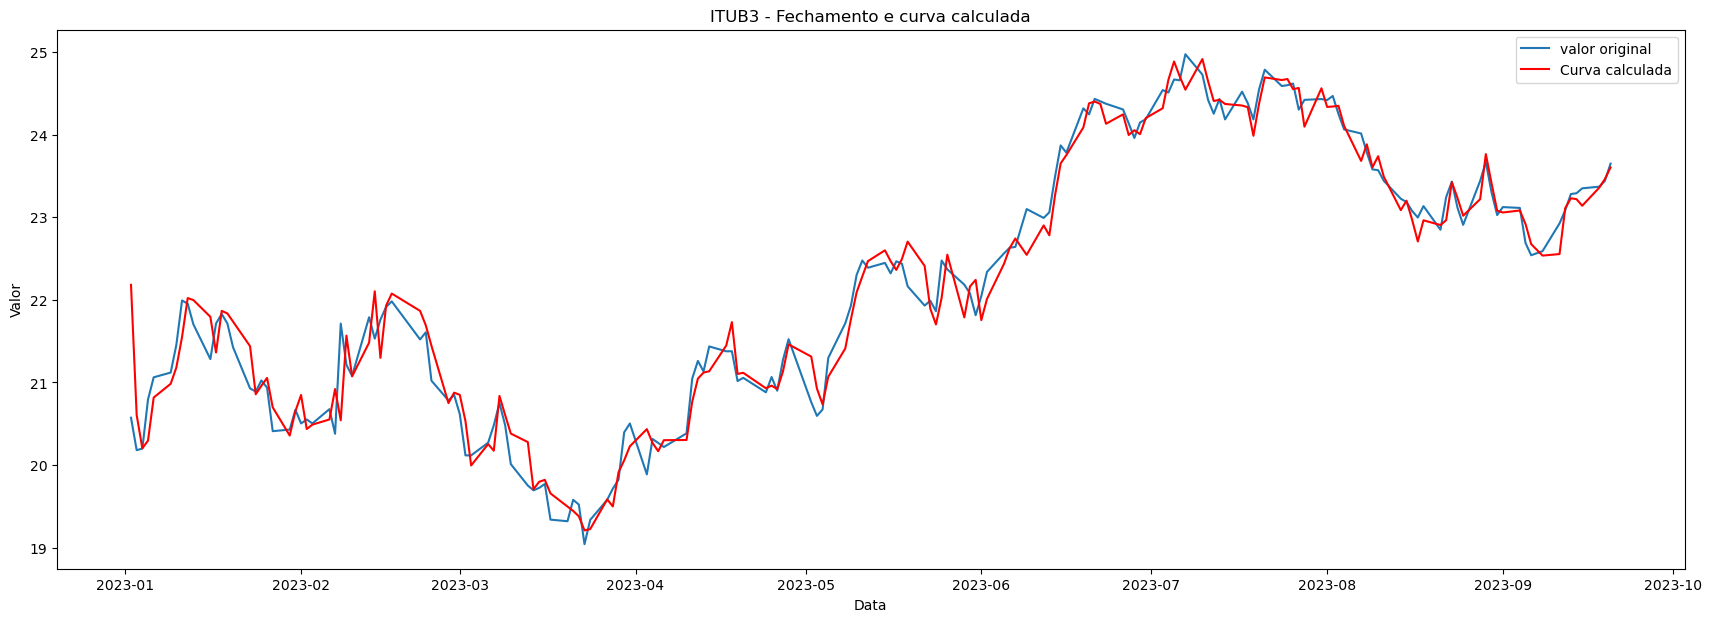

Erro calculado =  35.93056424788141


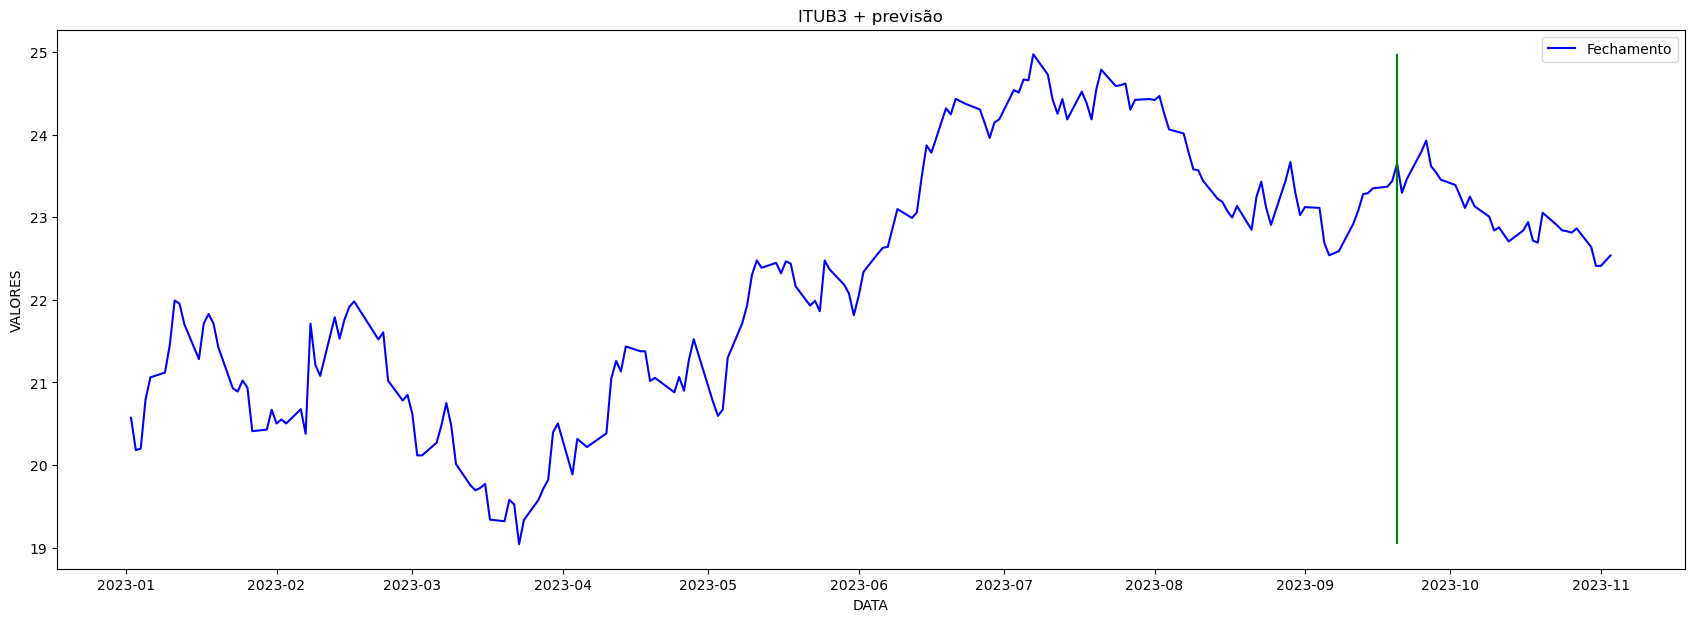

In [17]:
script()

Informe a ação que quer pesquisar: (ex CVCB3)cvcb3
Informe a ação data inicial: (dd/mm/aaaa)01/01/2023
Informe a ação data final: (dd/mm/aaaa)22/09/2023
Informe o grau de precisão da curva: 1
Informe o período em dias que quer prever: 1
[*********************100%%**********************]  1 of 1 completed


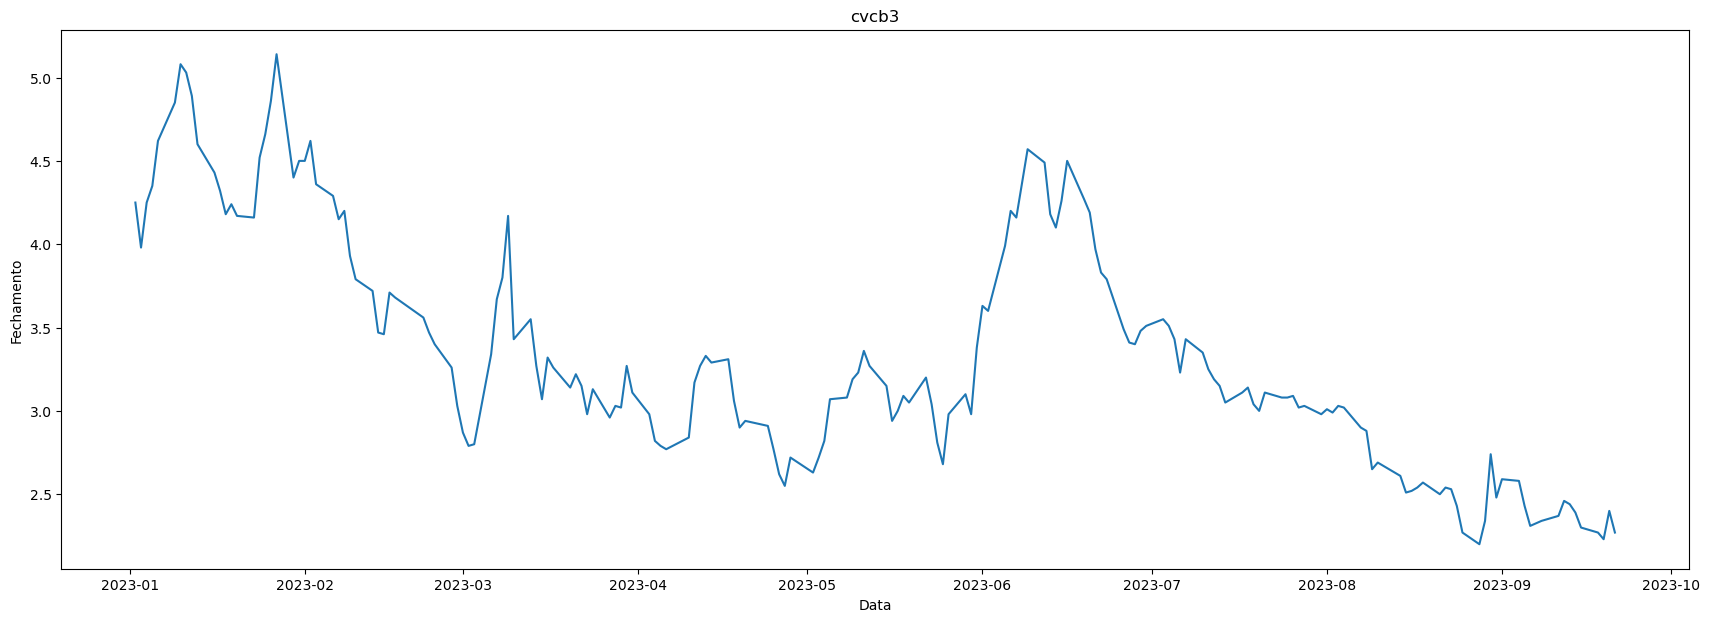

Calculando curva ótima


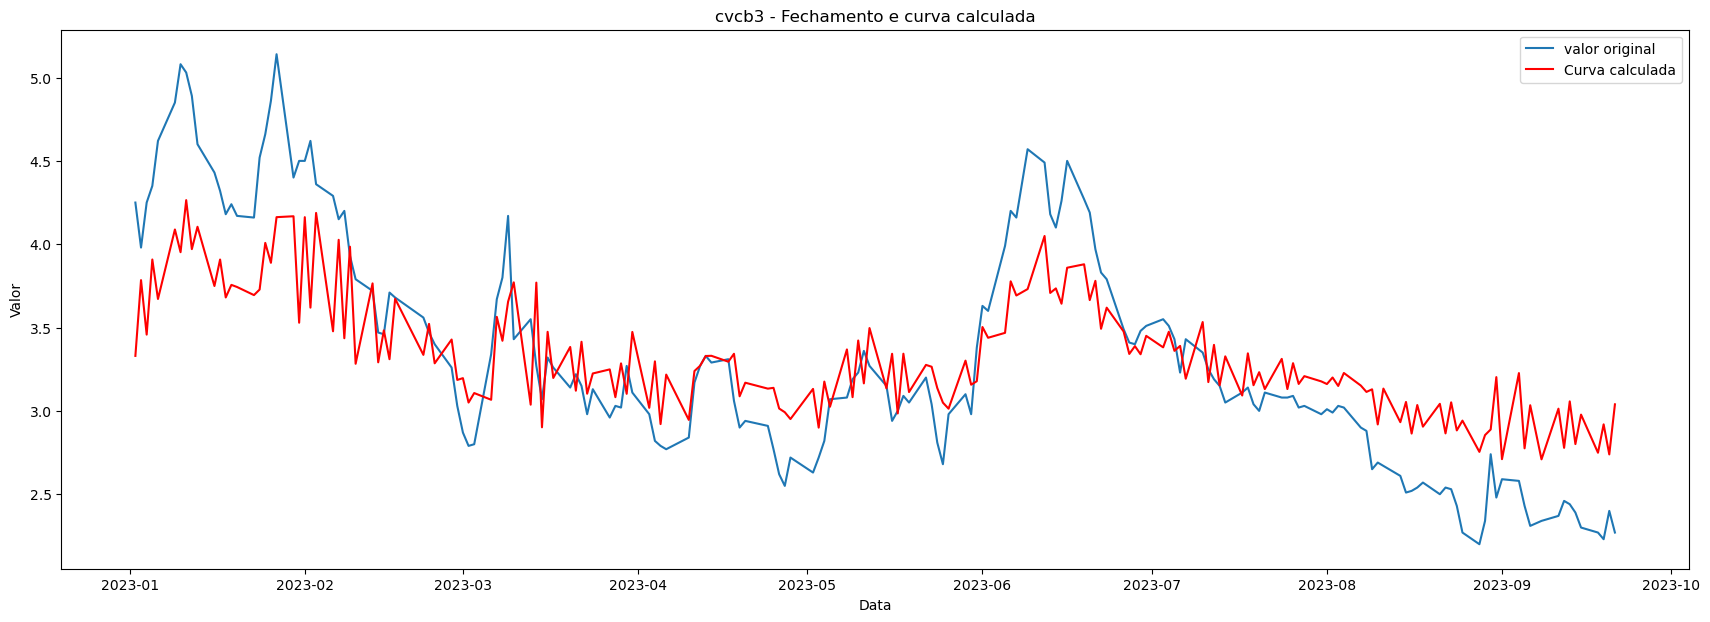

Erro calculado =  60.19699213912577


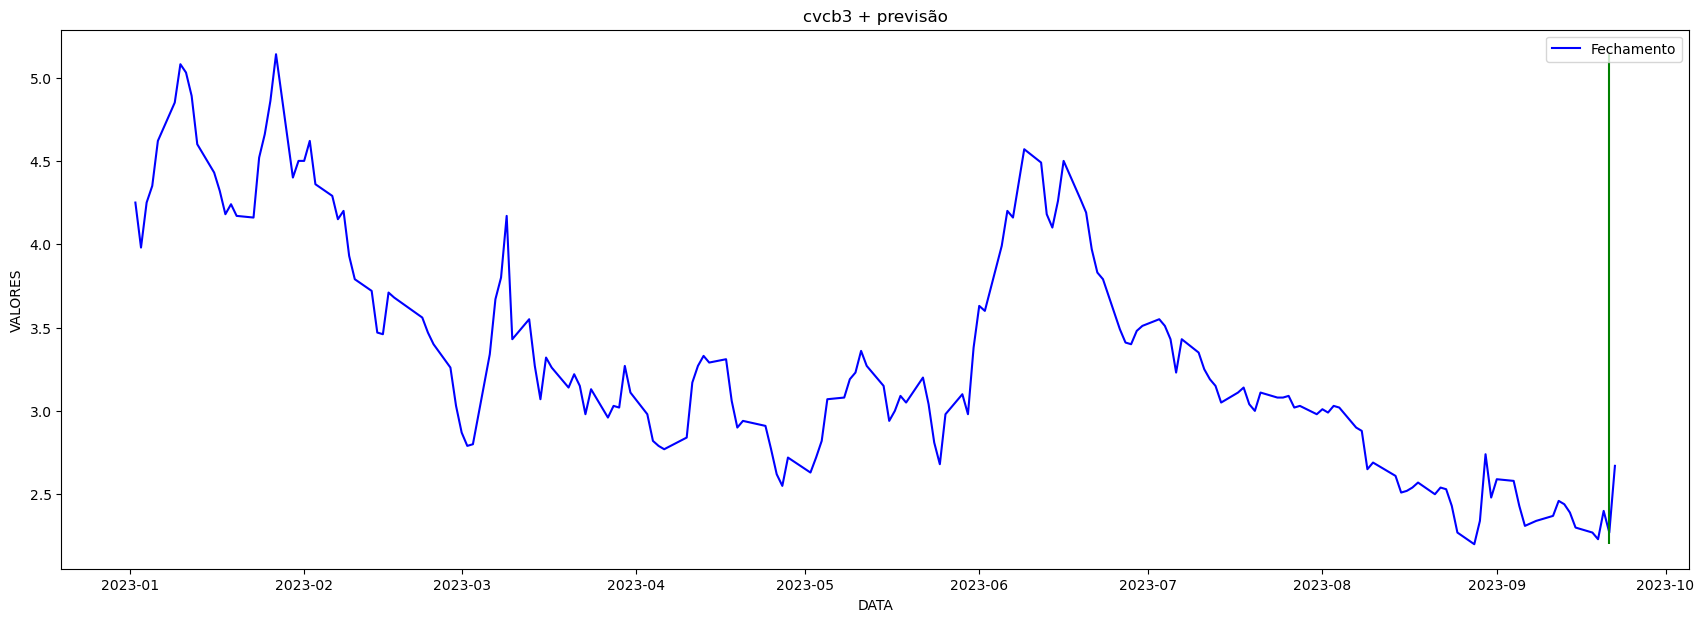

In [18]:
script()

Informe a ação que quer pesquisar: (ex CVCB3)cvcb3
Informe a ação data inicial: (dd/mm/aaaa)01/06/2023
Informe a ação data final: (dd/mm/aaaa)21/09/2023
Informe o grau de precisão da curva: 60
Informe o período em dias que quer prever: 30
[*********************100%%**********************]  1 of 1 completed


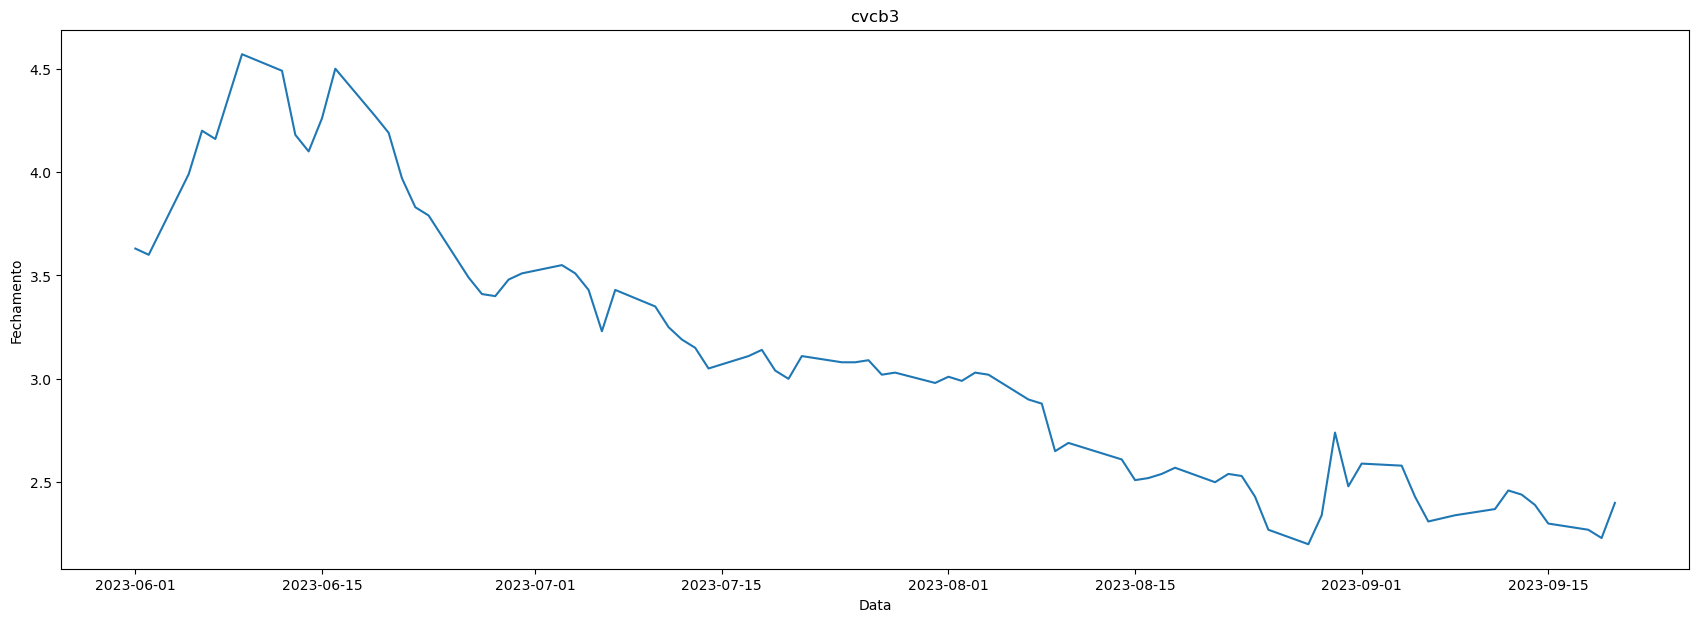

Calculando curva ótima


C:\Users\Paulo\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


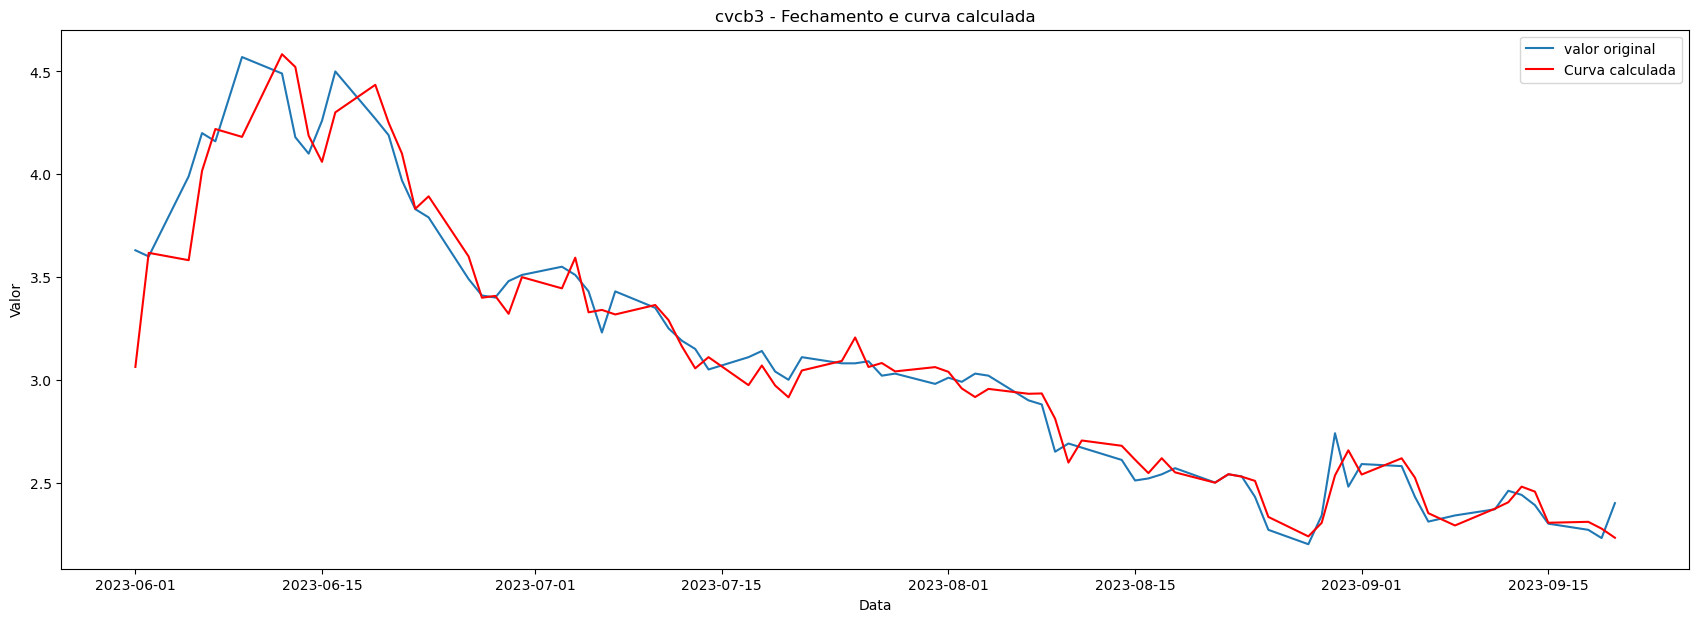

Erro calculado =  6.999584987675635


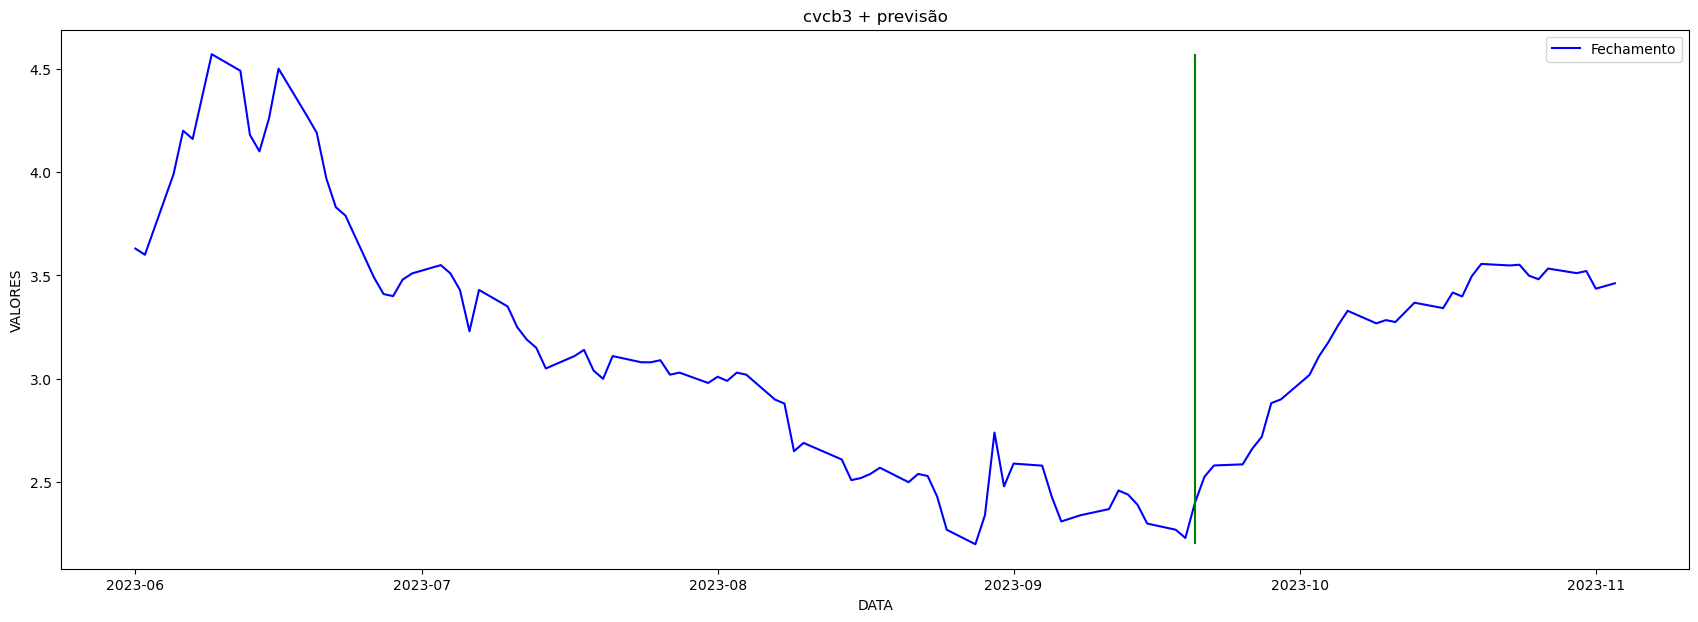

In [20]:
script()